# Kaggle Compitition - 2019 Data Science Bowl

## Executive Summary:
### Introduction
The competition, sponsored by PBS KIDS, is to gain insights into how media can help children learn important skills for success in school and life. The participants use anonymous gameplay data from PBS KIDS Measure Up! App to develop models that predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. Detailed description of the competition and data can be found on Kaggle throught the link below:
https://www.kaggle.com/c/data-science-bowl-2019

### Results
The best performing score was produced by the average of the predictions by CatBoost and LightGBM models. 
* Private Score: 0.543
* Public Score: 0.544
* Kaggle Rank: 167/3497 (Silver Medal, Top 5%)

### Approach
**Data Preparation**: The data preparation includes data processing, feature engineering, and feature selection. 
- **Data Processing**: Removing assessment sessions without outcomes and calculating the accuracy group for the train data.
- **Feature Engineering**: We generate over 20,000 features using information from the given numerical (e.g., time) and categorical features (e.g., event code, title, etc.) and statistics of the data extracted from the `event_data` column. Detail see [1.2 Data Processing](#1.2-Data-Processing). There were ~2000 unique features after removing the duplicate columns.
- **Feature Selection**: 400 most important features were selected for the final model. We ranked features through experiments with the Catboost model via local cross-validation. Note, permutation could have been a more general feature selection mechanism. However, since our final submission is based on Catboost and LightGBM, using important features ranked by the same model seems more relevant. Details of the op features can be found in [1.4 Feature Selection](#1.4-Feature-Selection). 

**Modeling**: We evaluated linear model, logistic regression, random forest, neural network, Catboost, and LightGBM algorithms. Based on the local cross-validation performance, we decided to choose the hybrid model with Catboost and LightGBM (best local cross-validation score) and single LightGBM model (best public score) as the two final submissions. 

**Model Evaluation**: We are aware that the public LB could be misleading especially when the model overfits the testing data used to calculate the public score. Our model selection relied on the local cross-validation. We performed 3-Fold cross-validation so that the size of the validation set was close to the actual testing set. We set the unit of analysis to be `installation_id` that was used to partition the data during the cross-validation. Ten iterations (total 30 validatinos) were performed and the average scores were used as the metric for model selection.

### Team Members
* [Vlad Pavlov](https://www.kaggle.com/vlpavlov)  
* [Kai Zhao](https://www.kaggle.com/miecky)

## Notebook Structure
* [1 - Functions & Variables](#1---Functions-&-Variables)
    * [1.1 Load Data](#1.1-Load-Data)
    * [1.2 Data Processing](#1.2-Data-Processing)
    * [1.3 Feature Engineering](#1.3-Feature-Engineering)
    * [1.4 Feature Selection](#1.4-Feature-Selection)
    * [1.5 Model](#1.5-Model)
    * [1.6 Model Evaluation](#1.6-Model-Evaluation)
* [2 - Model Execution](#2---Model-Execution)
    * [2.1 Process Train/Test Data](#2.1-Process-Train/Test-Data)
    * [2.2 Run Model: Local](#2.2-Run-Model:-Local)
    * [2.3 Run Model: Kaggle](#2.3-Run-Model:-Kaggle)

## Import Libraries

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import numpy as np
import plotly.express as px
import copy
from tqdm import tqdm
from numba import jit 
import gc
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
import warnings
import lightgbm as lgb

## 1 - Functions & Variables
Function were grouped into `load data`, `process data`, `feature engineering`, `model` and `model evaluation` modules. Their reltionship are entailed in the figure below.

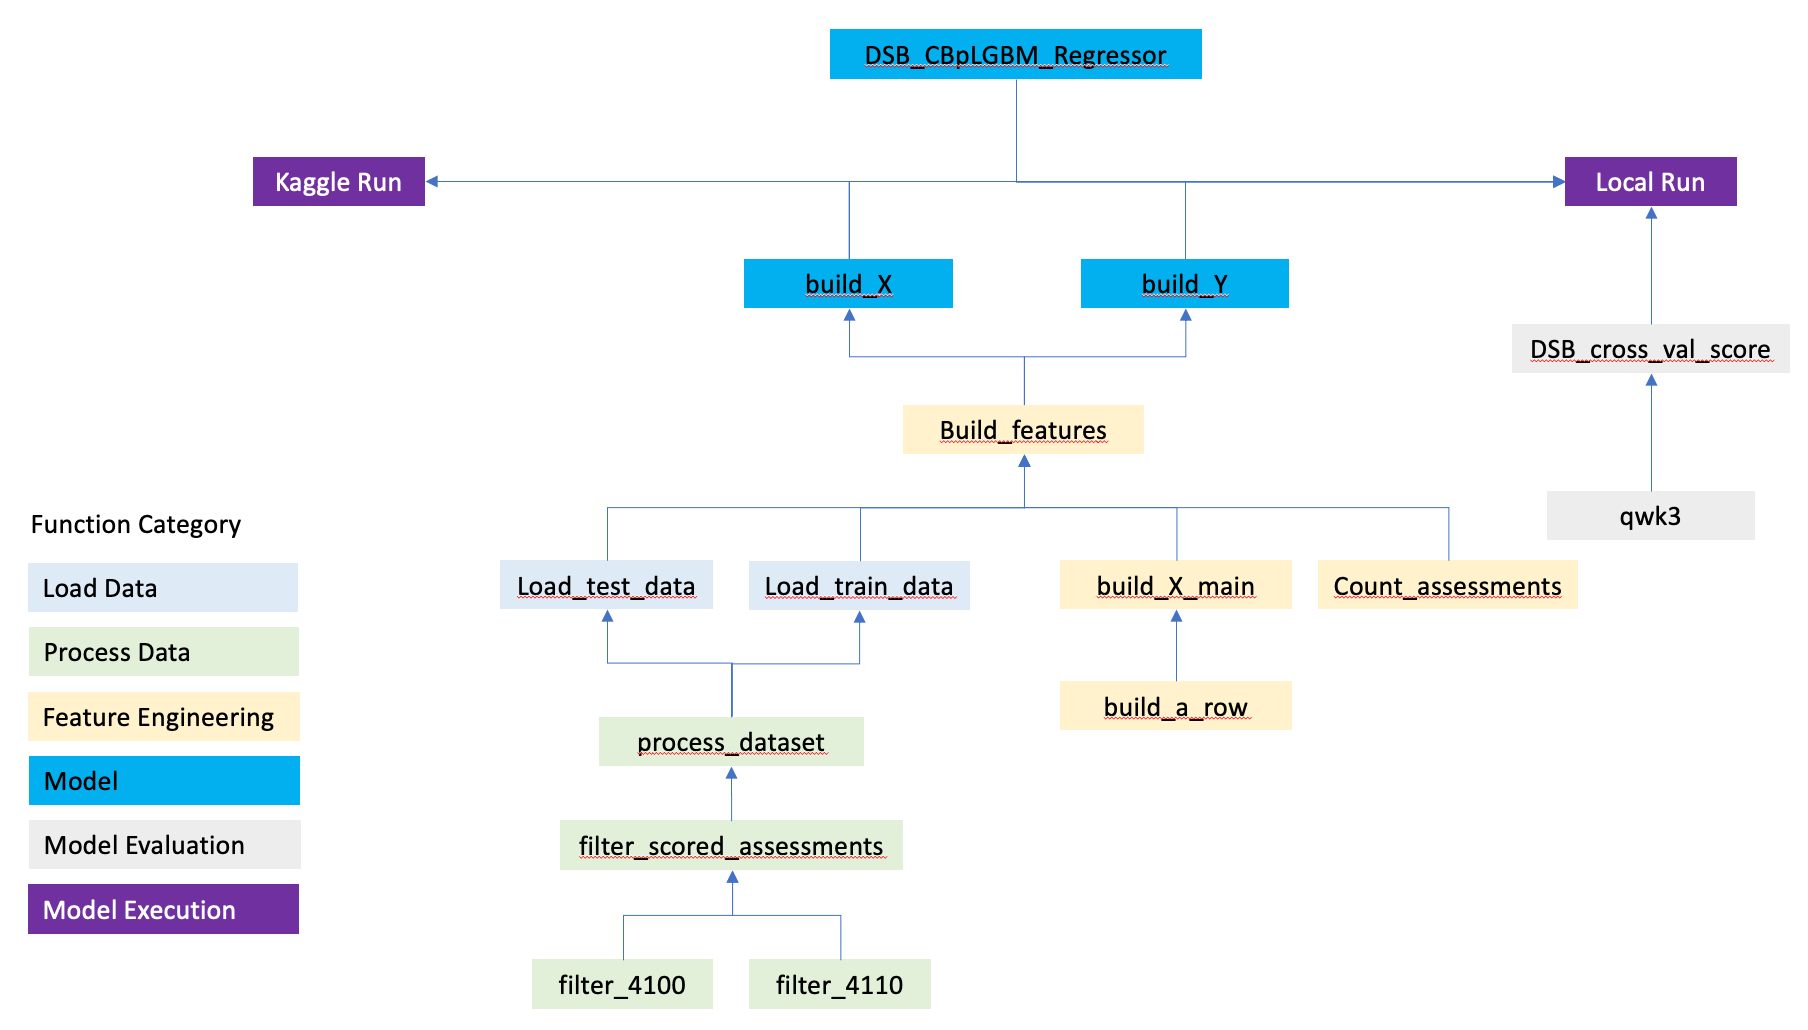

### 1.1 Load Data

Data will be loaded directly from Kaggle if running this notebook on Kaggle. Otherwise, data will be loaded from the local device.

#### Variables

In [ ]:
LOCAL_EXECUTION=False   # we will use this flag to indicate whether 
                        # the notebook is running on a local computer or
                        # on Kaggle cloud
        
PRINT_LOGS=True         # this flag will be passed as a default value 
                        # for "verbose" paramiters of all functions 
                        # to indicate whether they should print detailed logs

In [ ]:
# Variables for path of the data

if LOCAL_EXECUTION:
    ORIGINAL_DATA_DIR_PATH="./orig_data/"
    PREPROCESSED_DATA_DIR_PATH="./generated_data/"
else:
    ORIGINAL_DATA_DIR_PATH="/kaggle/input/data-science-bowl-2019/"
    PREPROCESSED_DATA_DIR_PATH="/kaggle/input/dsb-preprocessed-data/"

if LOCAL_EXECUTION:
    import qgrid as qg  
    qg.enable()
    qg.set_grid_option("forceFitColumns",False)

In [ ]:
# paramiters for efficient data loading via pd.read_csv()
# copied from https://www.kaggle.com/tdobson/30x-speedup-on-io

train_test_args = {
    'dtype': {
        'event_id': 'category',
        'game_session': 'category',
        'event_data': 'object',
        'installation_id': 'category',
        'event_count': 'int64',
        'event_code': 'category',
        'game_time': 'int64',
        'title': 'category',
        'type': 'category',
        'world': 'category'
    },
    "parse_dates": ['timestamp']
}

In [ ]:
# Global variables - will be filled with data a few pages later.

DSB_train_d=pd.DataFrame()  # Main datasets for DSB competition
DSB_test_d=pd.DataFrame()   

DSB_features=pd.DataFrame() # All features generated for a combined 
                            # train+test datased for all the assessment sessions
                            # (one session per row).

DSB_train_assessments={}    # Here we will store lists of assessment game_session id-s
DSB_test_assessments={}     

#### Functions

In [ ]:
# Function to load the test data

def load_test_data(verbose=PRINT_LOGS):
    
    global DSB_test_d
    
    test_filename=ORIGINAL_DATA_DIR_PATH + "test.csv"
    
    if verbose: 
        print(f"Loading process for file {test_filename} has started.")
        
    DSB_test_d=pd.read_csv(test_filename,**train_test_args )        
    DSB_test_d=process_dataset(DSB_test_d,remove_empty_assessments=False)
    
    gc.collect()
    
    if verbose: 
        print("File loading and pre-processing have finished. \n")
        print(f"Shape of DSB_test_d is {DSB_test_d.shape}")
        print(f"\nColumn names: {list(DSB_test_d.columns)} \n" )

In [ ]:
# Function to load the train data
# The function will check if preprocessed file exist to avoid duplicate work. If so load the preprocessed data.
# Otherwise, the function will load the new data.

def load_train_data(verbose=PRINT_LOGS,save_pickle=LOCAL_EXECUTION):
    
    global DSB_train_d
    
    train_filename=ORIGINAL_DATA_DIR_PATH + "train.csv"
    
    if verbose: 
        print(f"Loading process for file {train_filename} has started.")
        
    t_file_version_id=("TRAINPP_v" +"Jan18"+"_Added_" 
                       +str(len(BEST_EXT_NUM_VAR_NAME_SET)+2) 
                       + "_Vars_")
    
    original_filename_size=os.path.getsize(train_filename)
    
    preprocessed_filename=(PREPROCESSED_DATA_DIR_PATH 
                            + t_file_version_id 
                            + str(original_filename_size) +".pkl")
    
    # Check if preprocessed file exists. If so, load the preprocessed file.
    # Otherwise, load the new file.
    if os.path.exists(preprocessed_filename):
        if verbose: 
            print(f"Loading pre-processed file {preprocessed_filename}")
        DSB_train_d=pd.read_pickle(preprocessed_filename)
    else:
        if verbose: 
            print(f"Pre-processed file {preprocessed_filename} was NOT FOUND")
            print(f"Loading and pre-processing original file {train_filename} ")
        
        DSB_train_d=pd.read_csv(train_filename,**train_test_args )        
        DSB_train_d=process_dataset(DSB_train_d,remove_empty_assessments=True)
        
        if save_pickle:
            DSB_train_d.to_pickle(preprocessed_filename)
        
    gc.collect()
    
    if verbose: 
        print("File loading and pre-processing for train data have finished. \n")
        print(f"Shape of DSB_train_d is {DSB_train_d.shape}")
        print(f"\nColumn names: {list(DSB_train_d.columns)} \n" )

### 1.2 Data Processing

#### Variables

In [ ]:
# the full list of extra variables from 'event_data' with which we experimented
EXT_NUM_VAR_NAME_FULL_LIST=["round","level","misses" ,"tutorial_step"
                       ,"round_number","size","stage_number"
                       ,"dwell_time","time_played","duration"
                       ,"total_duration", "session_duration"
                       ,"shell_size","buglength","target_weight"
                       ,"table_weights", "dinosaur_count","distance"
                       ,"total_bowls","starting_weights","cloud_size"
                       ,"target_size","dinosaur_weight","target_water_level"
                      ]

# the set of best performing extra variables which was identified empirically
BEST_EXT_NUM_VAR_NAME_CB400_SET=set(['round', 'misses', 'size'
                                    , 'stage_number', 'duration'
                                    , 'total_duration'
                                    , 'session_duration'
                                    , 'buglength', 'target_weight'
                                    , 'distance'])


BEST_EXT_NUM_VAR_NAME_SET=BEST_EXT_NUM_VAR_NAME_CB400_SET

BEST_EXT_NUM_VAR_NAME_LIST=list(BEST_EXT_NUM_VAR_NAME_SET)

assert len(BEST_EXT_NUM_VAR_NAME_SET)==10

#### Functions

In [ ]:
# Functions for filtering the assessment events
def filter_4100(dataset):
    return (  (dataset.type=="Assessment")
            & (dataset.title != "Bird Measurer (Assessment)")
            & (dataset.event_code == "4100")  )
    
def filter_4110(dataset):
    return (  (dataset.type=="Assessment")
            & (dataset.title == "Bird Measurer (Assessment)")
            & (dataset.event_code == "4110")  )

def filter_scored_assessments(dataset):
    return filter_4100(dataset) | filter_4110(dataset)

In [ ]:
def process_dataset(data_input, remove_empty_assessments=True):

    data_s=copy.deepcopy(data_input)
    
    ####### Creatung a column named attempt_result #########
    
    if remove_empty_assessments:
        sessions_w_scored_assessments=data_s[filter_scored_assessments(data_s)].game_session.unique()
        installs_to_keep=data_s[data_s.game_session.isin(sessions_w_scored_assessments)].installation_id.unique()
    else:
        sessions_w_assessments=data_s[data_s.type=="Assessment"].game_session.unique()
        installs_to_keep=data_s[data_s.game_session.isin(sessions_w_assessments)].installation_id.unique()
    
    
    data_s=data_s[data_s.installation_id.isin(installs_to_keep)]

    data_s["attempt_result"]=np.nan

    data_s.loc[filter_scored_assessments(data_s) 
                & data_s.event_data.str.contains('"correct":true',regex=False),"attempt_result"
               ]="ASSESSMENT_GOOD_ATTEMPT"
    
    data_s.loc[filter_scored_assessments(data_s)
                & data_s.event_data.str.contains('"correct":false',regex=False),"attempt_result"
               ]="ASSESSMENT_BAD_ATTEMPT"
    
    
    data_s["attempt_result"]=data_s["attempt_result"].astype("category")
    
    ####### Creating a column named accuracy_group #########
    ## The column will mostly have NaNs, except for the very last attempt events in an assessment session
    ## for those events it will contain actual value of the accuracy
    
    assessments_with_attempts=data_s[ (data_s.attempt_result=="ASSESSMENT_BAD_ATTEMPT") 
                                     | (data_s.attempt_result=="ASSESSMENT_GOOD_ATTEMPT") ]
    
    assessment_results=pd.pivot_table(assessments_with_attempts, index="game_session"
                                  ,columns="attempt_result", values="event_id"
                                  ,aggfunc=len, fill_value=0)

    assessment_results.columns=list(assessment_results.columns)
    
    assessment_results["accuracy_group"]=0.0

    assessment_results["accuracy_group"]=assessment_results["ASSESSMENT_GOOD_ATTEMPT"]*3.0

    assessment_results.loc[(assessment_results.accuracy_group==3) 
                           & (assessment_results["ASSESSMENT_BAD_ATTEMPT"]==1)
                           ,"accuracy_group"]=2

    assessment_results.loc[(assessment_results.accuracy_group==3) 
                           & (assessment_results["ASSESSMENT_BAD_ATTEMPT"]>=2)
                           ,"accuracy_group"]=1

    final_attempts=copy.deepcopy(assessments_with_attempts[["game_session","attempt_result"]]
                                 .drop_duplicates(subset="game_session",keep="last"))
    final_attempts["old_index"]=final_attempts.index
    final_attempts=final_attempts.merge(assessment_results,on="game_session")
    final_attempts.index=final_attempts["old_index"]
    final_attempts.index.name="new_index"
    data_s["accuracy_group"]=np.nan
    data_s["accuracy_group"]=final_attempts["accuracy_group"]


    ####### Extracting numeric features from event_data #########
    for ext_var_name in BEST_EXT_NUM_VAR_NAME_SET:
        ext_var_full_name='"'+ ext_var_name + r'":\s*'
        extraction_condition="("+ext_var_full_name+")"
        extraction_outcome=r"([0-9]+)"
        rez=data_s.event_data.str.extract(extraction_condition+extraction_outcome)
        data_s[ext_var_name]=rez[1].astype("float")

    data_s.drop(columns="event_data", inplace=True)
    
    data_s.sort_values(by="timestamp",inplace=True)
    
    return data_s

### 1.3 Feature Engineering

#### Variables

In [ ]:
# ASSESSMENT_TITLES=list(set(DSB_train_d[DSB_train_d.type=="Assessment"].title.unique()) 
#                        | set(DSB_test_d[DSB_test_d.type=="Assessment"].title.unique()))

ASSESSMENT_TITLES_LIST=['Mushroom Sorter (Assessment)', 'Cauldron Filler (Assessment)', 'Chest Sorter (Assessment)'
                   , 'Bird Measurer (Assessment)', 'Cart Balancer (Assessment)']


ASSESSMENT_TITLES_SET=set(ASSESSMENT_TITLES_LIST)

assert len(ASSESSMENT_TITLES_LIST)==5

# NON_ASSESSMENT_TITLES=list(set(DSB_train_d[DSB_train_d.type!="Assessment"].title.unique())
#                            | set(DSB_test_d[DSB_test_d.type!="Assessment"].title.unique()))

NON_ASSESSMENT_TITLES_LIST =['Crystal Caves - Level 3', 'Chow Time', 'Dino Dive',
 'Slop Problem', 'Crystal Caves - Level 2', 'Scrub-A-Dub', 'Crystals Rule',
 'Happy Camel', 'Magma Peak - Level 2', 'Egg Dropper (Activity)', 'Fireworks (Activity)',
 'Flower Waterer (Activity)', 'Magma Peak - Level 1',
 'Welcome to Lost Lagoon!', 'Treasure Map', '12 Monkeys', 'Watering Hole (Activity)',
 'Sandcastle Builder (Activity)', 'Rulers', 'Ordering Spheres',
 'Tree Top City - Level 1', 'Bug Measurer (Activity)',
 'Leaf Leader', 'Tree Top City - Level 3', 'Crystal Caves - Level 1',
 'All Star Sorting', 'Air Show', 'Dino Drink', 'Pan Balance', 'Lifting Heavy Things',
 'Bottle Filler (Activity)', 'Tree Top City - Level 2',
 'Heavy, Heavier, Heaviest', 'Costume Box', 'Balancing Act',
 "Pirate's Tale", 'Chicken Balancer (Activity)', 'Bubble Bath', 'Honey Cake']

ALL_TITLES_LIST=ASSESSMENT_TITLES_LIST+NON_ASSESSMENT_TITLES_LIST

BEST_TITLES_CB400_LIST=['Mushroom Sorter (Assessment)', 'Cauldron Filler (Assessment)'
                           , 'Chest Sorter (Assessment)', 'Bird Measurer (Assessment)'
                           , 'Cart Balancer (Assessment)', 'Crystal Caves - Level 3'
                           , 'Chow Time', 'Crystal Caves - Level 2', 'Scrub-A-Dub'
                           , 'Crystals Rule', 'Happy Camel', 'Magma Peak - Level 2'
                           , 'Egg Dropper (Activity)', 'Fireworks (Activity)'
                           , 'Flower Waterer (Activity)', 'Watering Hole (Activity)'
                           , 'Sandcastle Builder (Activity)', 'Tree Top City - Level 1'
                           , 'Bug Measurer (Activity)', 'Tree Top City - Level 3'
                           , 'Crystal Caves - Level 1', 'All Star Sorting', 'Air Show'
                           , 'Dino Drink', 'Pan Balance', 'Tree Top City - Level 2'
                           , 'Chicken Balancer (Activity)']

BEST_TITLES_SET=set(BEST_TITLES_CB400_LIST)

assert len(ALL_TITLES_LIST)==44
assert len(BEST_TITLES_SET)==27


# ALL_TYPES_LIST=list(set(DSB_data["train"].type.unique()) | set(DSB_test_d.type.unique()))

ALL_TYPES_LIST=['Assessment', 'Activity', 'Clip', 'Game']
BEST_TYPES_CB400_LIST=['Assessment', 'Activity', 'Game']

BEST_TYPES_SET=set(BEST_TYPES_CB400_LIST)

assert len(ALL_TYPES_LIST)==4
assert len(BEST_TYPES_SET)==3

# ALL_WORLDS_LIST=list(set(DSB_train_d.world.unique()) | set(DSB_test_d.world.unique()))

ALL_WORLDS_LIST=['MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES', 'NONE']
BEST_WORLDS_CB400_LIST=['MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']
BEST_WORLDS_SET=set(BEST_WORLDS_CB400_LIST)

assert len(ALL_WORLDS_LIST)==4
assert len(BEST_WORLDS_SET)==3

ASSESSMENT_RESULTS_LIST=['ASSESSMENT_GOOD_ATTEMPT', 'ASSESSMENT_BAD_ATTEMPT']
ASSESSMENT_RESULTS_SET=set(ASSESSMENT_RESULTS_LIST)

assert len(ASSESSMENT_RESULTS_SET)==2

# ALL_EVENT_CODES_LIST=list(set(DSB_train_d.event_code.unique()) | set(DSB_test_d.event_code.unique()))

ALL_EVENT_CODES_LIST = ['3110', '4050', '2000', '4080', '5010', '2080', '3021',
                   '2010', '4021', '2060', '4035', '2083', '4022', '4100', 
                   '2081', '4070', '4025', '4010', '4230', '5000', '4031', 
                   '4095', '2025', '4020', '2075', '3120', '2030', '3020', 
                   '4030', '4090', '2050', '3010', '2020', '4045', '4110', 
                   '4235', '2040', '4040', '2035', '3121', '4220', '2070']

BEST_EVENT_CODES_CB400_LIST = ['3110', '2000', '3021', '4021', '4035', '4022'
                               , '4100', '4070', '4025', '4020', '3120', '2030'
                               , '3020', '4030', '4090', '3010', '2020', '4045'
                               , '4040', '2035', '3121', '2070']

BEST_EVENT_CODES_SET=set(BEST_EVENT_CODES_CB400_LIST)

assert len(ALL_EVENT_CODES_LIST)==42
assert len(BEST_EVENT_CODES_SET)==22

# ALL_EVENT_IDS_LIST=list(set(DSB_train_d.event_id.unique()) 
#                         | set(DSB_test_d.event_id.unique()))

BEST_EVENT_IDS_CB400_LIST=['c58186bf', 'e694a35b', '5f0eb72c', '15f99afc'
                           , 'c74f40cd', 'd3f1e122', '7da34a02', 'd185d3ea'
                           , '2230fab4', '3afb49e6', '160654fd', '5a848010'
                           , '84538528', 'ca11f653', '363c86c9', '0330ab6a'
                           , '923afab1', 'a44b10dc', '28520915', 'e9c52111'
                           , '2dcad279', '5290eab1', '88d4a5be', 'acf5c23f'
                           , '562cec5f', '6cf7d25c', 'e4f1efe6', '47026d5f'
                           , '9d29771f', '3ee399c3', 'ecaab346', '828e68f9'
                           , 'c51d8688', '709b1251', '71fe8f75', '884228c8'
                           , '30614231', '7372e1a5', 'f71c4741', '56817e2b'
                           , '4ef8cdd3', '0d1da71f', '5e812b27', '5c2f29ca'
                           , '1bb5fbdb', 'ac92046e', 'df4940d3', '04df9b66'
                           , '4a09ace1', '0db6d71d', 'a52b92d5', '27253bdc'
                           , '26fd2d99', 'b88f38da', '1325467d', '3323d7e9'
                           , '38074c54', 'f7e47413', '598f4598', '565a3990'
                           , 'a1bbe385', 'b5053438', '3bf1cf26']


BEST_EVENT_IDS_SET=set(BEST_EVENT_IDS_CB400_LIST)

assert len(BEST_EVENT_IDS_SET)==63

#### Functions

In [ ]:
#this function builds features for just one assessment session

def build_a_row(s,      # game_session for which we are building features
                s_data  # input dataframe, which contains all past
                        # events for the installation_id, to which s belongs,
                        # "past" means they happened before s started
               ):
    
    new_row={}
    new_row["game_session"]=s
    
    ###-ASSESSMENTS-SPECIFIC-################################################################################

    g=s_data.groupby(["title","attempt_result"])["type"].count()
    g_indx=list(g.index)
    for t in ASSESSMENT_TITLES_LIST:
        for r in ASSESSMENT_RESULTS_LIST:
            feature_name=r+" total attempt event count in title "+t 
            if (t,r) in g_indx:
                new_row[feature_name]=g[(t,r)]
                
    g=s_data[s_data.attempt_result.isin(ASSESSMENT_RESULTS_LIST)].groupby(["title"])["type"].count()
    for t in ASSESSMENT_TITLES_SET & set(g.index):
        feature_name="Total attempt event count in title "+t 
        new_row[feature_name]=g[t]

    g=s_data.groupby(["attempt_result"])["type"].count()
    for r in ASSESSMENT_RESULTS_SET & set(g.index):
        feature_name=r+" total attempt count"  
        new_row[feature_name]=g[r]

    new_row["ASSESSMENT total attempt count"]=(new_row["ASSESSMENT_GOOD_ATTEMPT total attempt count"]
                                               +new_row["ASSESSMENT_BAD_ATTEMPT total attempt count"])

    ###-SESSION-SPECIFIC-FEATURES#######################################################

    g=s_data[["event_code","timestamp"]].groupby("event_code").count()
    for e in BEST_EVENT_CODES_SET & set(g.index):
        new_row["Event_code "+ e +" preceding sessions event count"]=g.at[e,"timestamp"]

    g=s_data[["event_id","timestamp"]].groupby("event_id").count()
    for ei in BEST_EVENT_IDS_SET & set(g.index):
        new_row["Event_id "+ ei +" preceding sessions event_id count"]=g.at[ei,"timestamp"]
    
    
    ## Features based on variables, extracted from event_data <<<<<<<<<<<<<<<<<<<<<<<
    for e_var in ["accuracy_group"] + BEST_EXT_NUM_VAR_NAME_LIST:
        new_row["EXTR: " + e_var + " for preceding sessions count"]=s_data[e_var].count()
        new_row["EXTR: " + e_var + " for preceding sessions total"]=s_data[e_var].sum()
        new_row["EXTR: " + e_var + " for preceding sessions mean"]=s_data[e_var].mean()
        new_row["EXTR: " + e_var + " for preceding sessions median"]=s_data[e_var].median()
        new_row["EXTR: " + e_var + " for preceding sessions max"]=s_data[e_var].max()
    
        g=s_data[["title",e_var]].groupby("title").agg(["count","sum","max","mean","median"])
        for t in BEST_TITLES_SET & set(g.index):
            new_row["Title "+ t +" preceding sessions var count for "+e_var]=g.at[t,(e_var,"count")]
            new_row["Title "+ t +" preceding sessions var total for "+e_var]=g.at[t,(e_var,"sum")]
            new_row["Title "+ t +" preceding sessions var max for "+e_var]=g.at[t,(e_var,"max")]
            new_row["Title "+ t +" preceding sessions var mean for "+e_var]=g.at[t,(e_var,"mean")]
            new_row["Title "+ t +" preceding sessions var median for "+e_var]=g.at[t,(e_var,"median")]
        
        g=s_data[["event_id",e_var]].groupby("event_id").agg(["count","sum","max","mean","median"])
        for ei in BEST_EVENT_IDS_SET & set(g.index):
            new_row["event_id "+ ei +" preceding sessions var count for "+e_var]=g.at[ei,(e_var,"count")]
            new_row["event_id "+ ei +" preceding sessions var total for "+e_var]=g.at[ei,(e_var,"sum")]
            new_row["event_id "+ ei +" preceding sessions var max for "+e_var]=g.at[ei,(e_var,"max")]
            new_row["event_id "+ ei +" preceding sessions var mean for "+e_var]=g.at[ei,(e_var,"mean")]
            new_row["event_id "+ ei +" preceding sessions var median for "+e_var]=g.at[ei,(e_var,"median")]
        
        g=s_data[["event_code",e_var]].groupby("event_code").agg(["count","sum","max","mean","median"])
        for ec in BEST_EVENT_CODES_SET & set(g.index):
            new_row["event_code "+ ec +" preceding sessions var count for "+e_var]=g.at[ec,(e_var,"count")]
            new_row["event_code "+ ec +" preceding sessions var total for "+e_var]=g.at[ec,(e_var,"sum")]
            new_row["event_code "+ ec +" preceding sessions var max for "+e_var]=g.at[ec,(e_var,"max")]
            new_row["event_code "+ ec +" preceding sessions var mean for "+e_var]=g.at[ec,(e_var,"mean")]
            new_row["event_code "+ ec +" preceding sessions var median for "+e_var]=g.at[ec,(e_var,"median")]
        
        g=s_data[["type",e_var]].groupby("type").agg(["count","sum","max","mean","median"])
        for t in BEST_TYPES_SET & set(g.index):
            new_row["Type "+ t +" preceding sessions var count for "+e_var]=g.at[t,(e_var,"count")]
            new_row["Type "+ t +" preceding sessions var total for "+e_var]=g.at[t,(e_var,"sum")]
            new_row["Type "+ t +" preceding sessions var max for "+e_var]=g.at[t,(e_var,"max")]
            new_row["Type "+ t +" preceding sessions var mean for "+e_var]=g.at[t,(e_var,"mean")]
            new_row["Type "+ t +" preceding sessions var median for "+e_var]=g.at[t,(e_var,"median")]
        
        g=s_data[["world",e_var]].groupby("world").agg(["count","sum","max","mean","median"])
        for w in BEST_WORLDS_SET & set(g.index):
            new_row["World "+ w +" preceding sessions var count for "+e_var]=g.at[w,(e_var,"count")]
            new_row["World "+ w +" preceding sessions var total for "+e_var]=g.at[w,(e_var,"sum")]
            new_row["World "+ w +" preceding sessions var max for "+e_var]=g.at[w,(e_var,"max")]
            new_row["World "+ w +" preceding sessions var mean for "+e_var]=g.at[w,(e_var,"mean")]
            new_row["World "+ w +" preceding sessions var median for "+e_var]=g.at[w,(e_var,"median")]
        
        
    ## <<<<<<<<<<<<<<<<<<<<<<<
    
    s_data.drop_duplicates(subset=["game_session"],keep="last",inplace=True)
    s_data["session_count"]=1

    new_row["preceding sessions count"]=s_data.game_session.nunique()
    new_row["preceding sessions total duration"]=s_data.game_time.sum()
    new_row["preceding sessions mean duration"]=s_data.game_time.mean()
    new_row["preceding sessions median duration"]=s_data.game_time.median()
    new_row["preceding sessions max duration"]=s_data.game_time.max()
    
    new_row["preceding sessions total event count"]=s_data.event_count.sum()
    new_row["preceding sessions mean event count per session"]=s_data.event_count.mean()
    new_row["preceding sessions median event count per session"]=s_data.event_count.median()
    new_row["preceding sessions max event count per session"]=s_data.event_count.max()
    

    ## ---------------
    
    g=s_data[["type","game_session","game_time","event_count","session_count"]
            ].groupby("type").agg(["mean","median","max","sum"])
    for t in BEST_TYPES_SET & set(g.index):
        new_row["Type "+ t +" preceding sessions median duration"]=g.at[t,("game_time","median")]
        new_row["Type "+ t +" preceding sessions median event count"]=g.at[t,("event_count","median")]
        new_row["Type "+ t +" preceding sessions mean duration"]=g.at[t,("game_time","mean")]
        new_row["Type "+ t +" preceding sessions mean event count"]=g.at[t,("event_count","mean")]
        new_row["Type "+ t +" preceding sessions max duration"]=g.at[t,("game_time","max")]
        new_row["Type "+ t +" preceding sessions max event count"]=g.at[t,("event_count","max")]
        new_row["Type "+ t +" preceding sessions total count"]=g.at[t,("session_count","sum")]
        new_row["Type "+ t +" preceding sessions total duration"]=g.at[t,("game_time","sum")]
        new_row["Type "+ t +" preceding sessions total event count"]=g.at[t,("event_count","sum")]
    
    g=s_data[["world","game_session","game_time","event_count","session_count"]
            ].groupby("world").agg(["mean","median","max","sum"])
    for w in BEST_WORLDS_SET & set(g.index):
        new_row["World "+ w +" preceding sessions median duration"]=g.at[w,("game_time","median")]
        new_row["World "+ w +" preceding sessions median event count"]=g.at[w,("event_count","median")]
        new_row["World "+ w +" preceding sessions mean duration"]=g.at[w,("game_time","mean")]
        new_row["World "+ w +" preceding sessions mean event count"]=g.at[w,("event_count","mean")]
        new_row["World "+ w +" preceding sessions max duration"]=g.at[w,("game_time","max")]
        new_row["World "+ w +" preceding sessions max event count"]=g.at[w,("event_count","max")]
        new_row["World "+ w +" preceding sessions total count"]=g.at[w,("session_count","sum")]
        new_row["World "+ w +" preceding sessions total duration"]=g.at[w,("game_time","sum")]
        new_row["World "+ w +" preceding sessions total event count"]=g.at[w,("event_count","sum")]
    
    g=s_data[["title","game_session","game_time","event_count","session_count"]
            ].groupby("title").agg(["mean","median","max","sum"])
    for t in BEST_TITLES_SET & set(g.index):
        new_row["Title "+ t +" preceding sessions median duration"]=g.at[t,("game_time","median")]
        new_row["Title "+ t +" preceding sessions median event count"]=g.at[t,("event_count","median")]
        new_row["Title "+ t +" preceding sessions mean duration"]=g.at[t,("game_time","mean")]
        new_row["Title "+ t +" preceding sessions mean event count"]=g.at[t,("event_count","mean")]
        new_row["Title "+ t +" preceding sessions max duration"]=g.at[t,("game_time","max")]
        new_row["Title "+ t +" preceding sessions max event count"]=g.at[t,("event_count","max")]
        new_row["Title "+ t +" preceding sessions total count"]=g.at[t,("session_count","sum")]
        new_row["Title "+ t +" preceding sessions total duration"]=g.at[t,("game_time","sum")]
        new_row["Title "+ t +" preceding sessions total event count"]=g.at[t,("event_count","sum")]
    
    s_data.sort_values(by="timestamp",ascending=False)
    
    if len(s_data)>0:
        p_title=s_data.loc[s_data.index[0],"title"]
        p_duration=s_data.loc[s_data.index[0],"game_time"]
        p_events=s_data.loc[s_data.index[0],"event_count"]
        new_row[f"Previous session had a duration of"]=p_duration
        new_row[f"Previous session had this number of events"]=p_events
        new_row[f"Previous session had a title of"]=p_title
    else:
        new_row[f"Previous session had a title of"]="_NOT_A_TITLE_"
    
    return new_row   

In [ ]:
# This function takes a dataset and a list of assesment sessions, 
# and iterates through the list to generate all the features for each of the sessions.
# There are a few tricks implemented here to optimize for memory usage and speed

def build_X_main(all_target_sessions,       # A list of assesment sessions
                 raw_data,                  # A full dataset
                 columns_to_keep_list=[]    # An empty list if we are running feature generation 
                                            # for the first time, which means we are free to de-dup 
                                            # in any way we want to; otherwise a list of column names to keep
                ):
    
     
    sessions_info=raw_data[raw_data.game_session.isin(all_target_sessions)
                          ][["game_session","title","world"]].drop_duplicates()

    all_rows=[]
    partial_dataframes=[]
    
    raw_data.sort_values(by="timestamp",inplace=True)
    
    session_start_times=raw_data.drop_duplicates(subset=["game_session"]
                                                 ,keep="first")[["game_session"
                                                                 ,"timestamp"
                                                                 ,"installation_id"]]
    session_start_times.set_index("game_session",inplace=True)
    session_start_times.columns=["start_time", "installation_id"]
    
    raw_data_groupped_by_inst=raw_data.groupby("installation_id")
    
    iteration_counter=0
    
    for s_installation_id, installation_data in tqdm(raw_data_groupped_by_inst):
        
        sessions_in_installation_list=list(installation_data.game_session.unique())
        
        sessions_to_process_in_inst_list=list(set(sessions_in_installation_list) 
                                              & set(all_target_sessions)
                                             )
        
        for s in sessions_to_process_in_inst_list:
            s_start_time=session_start_times.loc[s,"start_time"]
            s_data=copy.deepcopy(installation_data[ installation_data.timestamp < s_start_time ])
            s_data.sort_values(by="timestamp",inplace=True)
            new_row=build_a_row(s,s_data)        
            all_rows.append(new_row)    
    
        # every 500 iterations we are optimizing memory usage  
        iteration_counter+=1           
        if (iteration_counter%500)==0:  
            partial_dataframes.append(pd.DataFrame(all_rows)
                                      .set_index("game_session"))
            all_rows=[]
            gc.collect() 
    
    if len(all_rows)>0:
        partial_dataframes.append(pd.DataFrame(all_rows)
                                  .set_index("game_session"))
        all_rows=[]
    
    result=pd.concat(partial_dataframes, ignore_index=False, sort=True)
    
    result.sort_index(inplace=True)

    result=result.merge(sessions_info, on="game_session")

    result.set_index("game_session", inplace=True)
    
    result.sort_index(inplace=True)
    
    categorical_columns_list=["title","world" ,"Previous session had a title of"]
    for c in categorical_columns_list:
            result[c]=result[c].astype("category")
    
    categorical_columns_df=copy.deepcopy(result[categorical_columns_list])
    result.drop(columns=categorical_columns_list,inplace=True)
    result=result.astype("float")
    result.fillna(0,inplace=True)
    
    if len(columns_to_keep_list)==0:
        # removing duplicating features    
        result=result.T.drop_duplicates().T
        result=result.join(categorical_columns_df)
    else:
        # keeping only pre-defined features
        result=result.join(categorical_columns_df)
        final_list_of_columns=list(set(columns_to_keep_list)
                                   & set(result.columns))
        result=result[final_list_of_columns]
    
    del partial_dataframes
    
    gc.collect()
    
    return result

In [ ]:
## The function takes a dataset (train or test or combinded) 
## and returns important groups of Assessment sessions 
## (as lists of session ID-s)
def count_assessments(raw_data, verbose=PRINT_LOGS):    
    
    if verbose:
        print(f"Starting counting assessments for a dataset with \n"
              ,f"{len(raw_data)} lines and the following columns:\n"
              ,list(raw_data.columns))
    
    result_ids={}
    
    raw_data.sort_values(by="timestamp",inplace=True)

    result_ids["all"]=list(raw_data[raw_data.type=="Assessment"].game_session.unique())

    result_ids["all_w_outcomes"]=list(raw_data[(raw_data.type=="Assessment") & 
                                               (raw_data.attempt_result.notnull())
                                              ].game_session.unique())

    last_assessments=raw_data[raw_data.game_session.isin(result_ids["all"])
                             ].drop_duplicates(subset=["installation_id"], keep="last")

    result_ids["last"]=list(last_assessments.game_session.unique())
    
    last_assessments_w_outcomes=raw_data[raw_data.game_session.isin(result_ids["all_w_outcomes"])
                                        ].drop_duplicates(subset=["installation_id"], keep="last")

    result_ids["last_w_outcomes"]=list(last_assessments_w_outcomes.game_session.unique())
    
    if verbose:
        print("Assessments: ",{k:len(result_ids[k]) for k in result_ids})
        print(" \n")
    
    return result_ids

In [ ]:
# This function first loads test/train datasets, and uses them to generate features,
# which are then saved into a file.
# The next time the function is executed, it will check if the file exists, and (if yes)
# it will load the features from the file instead of calculating them again.
# However, when the features are loaded from the file, an additional check is executed 
# to see if the file covers all instalaltion_id-s from the test dataset.
# If some instalaltion_id-s are missing, for these id-s the features will be calucated.
# The final resul is storied into a global dataframe named DSB_features
# This multi-tier logic is implemented in order to be able to pre-calculate features locally for 
# train.csv and public version of test.csv, and later calculate features for additional 
# installation_id-s from a private version of test.csv

def build_features(save_pickle=LOCAL_EXECUTION
                   , verbose=PRINT_LOGS
                   , features_to_keep=[]   # Non-empty list if the function should keep only 
                                           # specific features (defined in this list),
                                           # otherwise all possible features will be created 
                                           # and then the list will be reduced  
                                           # by auto de-dup procedure 
                  ):
    
    global DSB_features, DSB_train_d, DSB_test_d, DSB_train_assessments, DSB_test_assessments
    
    if(verbose): 
        print("------------------------------------")
        print("Starting working on features")
    
    if len(DSB_train_d)==0:
        load_train_data(verbose=verbose, save_pickle=save_pickle)
        
    if len(DSB_test_d)==0:
        load_test_data(verbose=verbose)
        
    if len(DSB_train_assessments)==0:
        DSB_train_assessments=count_assessments(DSB_train_d,verbose=verbose)
    
    if len(DSB_test_assessments)==0:
        DSB_test_assessments=count_assessments(DSB_test_d,verbose=verbose)
        
    all_assessments_list=(DSB_train_assessments["all"]
                        +DSB_test_assessments["all"])
    
    total_num_of_assessments=len(all_assessments_list)
        
    f_file_version_id=("FEATURESPP_" 
                       + str(len(BEST_EXT_NUM_VAR_NAME_SET)) 
                       + "Jan18_V1")
    
    f_file_name=(PREPROCESSED_DATA_DIR_PATH 
                 + f_file_version_id + ".pkl")
    

    if(verbose):
        print(f"A total set of {total_num_of_assessments} assessment sessions needs features")

    if not os.path.exists(f_file_name):
        
        if(verbose):
            print(f"File {f_file_name} does not exist")
            print("Starting a process of building features for all sessions")
        
        train_features_df=build_X_main(DSB_train_assessments["all"]
                                       ,DSB_train_d
                                       ,features_to_keep)
        
        test_features_df=build_X_main(DSB_test_assessments["all"]
                                      ,DSB_test_d
                                      ,list(train_features_df.columns))
        
        DSB_features=pd.concat([train_features_df ,test_features_df]
                               ,ignore_index=False
                               ,sort=True)
        
        if save_pickle:
            if(verbose):
                print(f"Saving file {f_file_name}")
                
            features_to_save=pd.concat([train_features_df
                                        ,test_features_df.drop(index=[test_features_df.index[10]
                                                                      ,test_features_df.index[-10]])]
                                       ,ignore_index=False)
                        # we are dropping two game_sessions in order 
                        # to aways test feature re-building functionality 
                        # (which should be triggered automatically when
                        # loading pre-processed file with missing sessions)
            features_to_save.to_pickle(f_file_name)
    else:
        if(verbose):
            print(f"Loading file {f_file_name} ")
                  
        prebuilt_features_df=pd.read_pickle(f_file_name)
        
        assert prebuilt_features_df.index.name=="game_session"
        
        if len(features_to_keep)>0:
            good_features=list(set(features_to_keep) 
                               & set(list(prebuilt_features_df.columns)))
            bad_features=list(set(list(prebuilt_features_df.columns))
                              -set(features_to_keep))
            if len(bad_features)>0:
                prebuilt_features_df.drop(columns=bad_features, inplace=True)
        
        prebuilt_assessments_list=list(prebuilt_features_df.index.unique())
        
        if(verbose):
            print(f"The file contains features for "
                  +f"{len(prebuilt_assessments_list)} assessment sessions ")
        
        missing_assessments_list=list(set(all_assessments_list)
                                      -set(prebuilt_assessments_list))
        
        if len(missing_assessments_list)>0:
            
            test_missing_inst_ids_list=list(DSB_test_d[DSB_test_d
                                                       .game_session
                                                       .isin(missing_assessments_list)
                                                      ].installation_id.unique())
            
            train_missing_inst_ids_list=list(DSB_train_d[DSB_train_d
                                                         .game_session
                                                         .isin(missing_assessments_list)
                                                        ].installation_id.unique())
            
            assert len(train_missing_inst_ids_list)==0
            assert len(test_missing_inst_ids_list)>0
            
            if(verbose):
                print(f"{len(missing_assessments_list)} sessions "
                      + f"from {len(test_missing_inst_ids_list)} installations were not found in the file")
                print("Starting a process of building features for missing sessions")
            
            missing_instids_df=copy.deepcopy(DSB_test_d[DSB_test_d
                                                        .installation_id
                                                        .isin(test_missing_inst_ids_list)
                                                       ])

            missing_instids_df["installation_id"]= missing_instids_df["installation_id"].astype("object")
            
            missing_features_df=build_X_main(missing_assessments_list
                                             ,missing_instids_df
                                             ,columns_to_keep_list=list(prebuilt_features_df.columns))

            DSB_features=pd.concat([prebuilt_features_df
                                    , missing_features_df]
                                   ,ignore_index=False
                                   ,sort=True)
        else:
            print(f"No missing assessments identified while processing file {f_file_name}")
            print(f"THIS IS AN ERROR: there is always at least one missing assessment !!!!")
            print("However, we are moving forward with just loaded assessments")
            DSB_features=prebuilt_features_df
              
    if "Previous session had a title of" in list(DSB_features.columns):
            DSB_features["Previous session had a title of"
                        ]=DSB_features["Previous session had a title of"
                                      ].astype("category")
    if(verbose): 
        print("Feature-building process is complete")
        print(f"DSB_features.shape is {DSB_features.shape}")

### 1.4 Feature Selection

400 most important features were selected for the final model. We ranked features through experiment with the Catboost model via local cross-validation. Note, permutation could have been a more general feature selection mechanism. However, since our final submission is based on Catboost and LightGBM, using important features ranked by the same model seems more relevant.

#### Variables

In [ ]:
# List of top-performig CatBoost features
# identified via experiments
TOP_CB400_FEATURES_LIST=['title',
 'EXTR: accuracy_group for preceding sessions mean',
 'EXTR: accuracy_group for preceding sessions median',
 'world',
 'event_code 4100 preceding sessions var mean for accuracy_group',
 'World TREETOPCITY preceding sessions var mean for accuracy_group',
 'EXTR: misses for preceding sessions mean',
 'event_code 2030 preceding sessions var mean for misses',
 'World TREETOPCITY preceding sessions var median for accuracy_group',
 'Event_code 4070 preceding sessions event count',
 'event_code 4100 preceding sessions var median for accuracy_group',
 'Type Game preceding sessions var mean for misses',
 'event_code 4020 preceding sessions var median for duration',
 'Event_id 27253bdc preceding sessions event_id count',
 'event_code 3021 preceding sessions var mean for total_duration',
 'preceding sessions mean event count per session',
 'Type Assessment preceding sessions var mean for total_duration',
 'Title Sandcastle Builder (Activity) preceding sessions var mean for total_duration',
 'event_code 2030 preceding sessions var median for duration',
 'Event_code 2000 preceding sessions event count',
 'event_id 1bb5fbdb preceding sessions var mean for duration',
 'preceding sessions max duration',
 'Type Assessment preceding sessions var median for duration',
 'event_id 1bb5fbdb preceding sessions var median for duration',
 'Type Game preceding sessions var median for round',
 'event_id 84538528 preceding sessions var median for duration',
 'Event_id 7372e1a5 preceding sessions event_id count',
 'Title Sandcastle Builder (Activity) preceding sessions var median for total_duration',
 'Type Activity preceding sessions median event count',
 'Type Assessment preceding sessions var mean for duration',
 'event_code 2030 preceding sessions var mean for duration',
 'Title All Star Sorting preceding sessions var mean for total_duration',
 'event_code 4035 preceding sessions var median for duration',
 'event_code 3121 preceding sessions var mean for duration',
 'event_code 4020 preceding sessions var mean for duration',
 'event_code 3120 preceding sessions var median for duration',
 'event_code 3121 preceding sessions var median for duration',
 'event_id 5a848010 preceding sessions var mean for duration',
 'Title Chest Sorter (Assessment) preceding sessions var median for accuracy_group',
 'Title Chest Sorter (Assessment) preceding sessions var mean for accuracy_group',
 'Type Assessment preceding sessions var median for total_duration',
 'Type Game preceding sessions median duration',
 'event_code 3121 preceding sessions var max for duration',
 'event_code 3020 preceding sessions var mean for total_duration',
 'World MAGMAPEAK preceding sessions var mean for misses',
 'event_code 3120 preceding sessions var total for duration',
 'Title Scrub-A-Dub preceding sessions var mean for size',
 'Title Happy Camel preceding sessions var mean for misses',
 'World MAGMAPEAK preceding sessions var mean for total_duration',
 'EXTR: duration for preceding sessions median',
 'event_code 4070 preceding sessions var count for round',
 'event_code 3121 preceding sessions var total for duration',
 'Type Assessment preceding sessions mean event count',
 'EXTR: total_duration for preceding sessions median',
 'Type Assessment preceding sessions median duration',
 'Title Dino Drink preceding sessions var median for total_duration',
 'Type Game preceding sessions median event count',
 'Title Fireworks (Activity) preceding sessions var mean for total_duration',
 'Type Activity preceding sessions median duration',
 'World CRYSTALCAVES preceding sessions var mean for total_duration',
 'Type Activity preceding sessions var median for total_duration',
 'Title Chest Sorter (Assessment) preceding sessions var max for accuracy_group',
 'event_code 4025 preceding sessions var median for duration',
 'Type Activity preceding sessions var median for duration',
 'EXTR: total_duration for preceding sessions mean',
 'event_code 3020 preceding sessions var median for total_duration',
 'Title Mushroom Sorter (Assessment) preceding sessions var median for accuracy_group',
 'event_code 3110 preceding sessions var mean for duration',
 'event_code 4035 preceding sessions var max for duration',
 'World TREETOPCITY preceding sessions var median for duration',
 'event_code 3110 preceding sessions var max for duration',
 'World CRYSTALCAVES preceding sessions mean event count',
 'event_code 3010 preceding sessions var mean for total_duration',
 'event_id 84538528 preceding sessions var mean for duration',
 'Type Game preceding sessions var mean for round',
 'Title Flower Waterer (Activity) preceding sessions var median for duration',
 'Type Activity preceding sessions mean event count',
 'Title Bird Measurer (Assessment) preceding sessions var mean for accuracy_group',
 'event_code 3120 preceding sessions var mean for duration',
 'World CRYSTALCAVES preceding sessions var median for duration',
 'Type Assessment preceding sessions median event count',
 'Title Crystal Caves - Level 3 preceding sessions total count',
 'Title Happy Camel preceding sessions var median for misses',
 'event_code 3110 preceding sessions var median for duration',
 'Type Activity preceding sessions var mean for total_duration',
 'event_code 4035 preceding sessions var mean for duration',
 'event_id 4ef8cdd3 preceding sessions var median for duration',
 'preceding sessions max event count per session',
 'World CRYSTALCAVES preceding sessions var median for total_duration',
 'Title Chest Sorter (Assessment) preceding sessions var mean for total_duration',
 'preceding sessions mean duration',
 'event_code 4035 preceding sessions var count for duration',
 'Title Scrub-A-Dub preceding sessions var mean for duration',
 'World CRYSTALCAVES preceding sessions median event count',
 'event_code 3010 preceding sessions var median for total_duration',
 'Title Mushroom Sorter (Assessment) preceding sessions var mean for accuracy_group',
 'event_id 0d1da71f preceding sessions var median for duration',
 'event_code 4020 preceding sessions var mean for size',
 'World CRYSTALCAVES preceding sessions var mean for misses',
 'EXTR: duration for preceding sessions mean',
 'preceding sessions total duration',
 'event_id f7e47413 preceding sessions var median for duration',
 'EXTR: round for preceding sessions median',
 'event_id 26fd2d99 preceding sessions var mean for size',
 'event_id 04df9b66 preceding sessions var total for total_duration',
 'World TREETOPCITY preceding sessions total count',
 'Title Air Show preceding sessions var mean for duration',
 'World TREETOPCITY preceding sessions max duration',
 'Type Activity preceding sessions var mean for duration',
 'ASSESSMENT_BAD_ATTEMPT total attempt event count in title Cauldron Filler (Assessment)',
 'event_code 4035 preceding sessions var total for duration',
 'Type Assessment preceding sessions max duration',
 'Type Assessment preceding sessions mean duration',
 'Event_code 4025 preceding sessions event count',
 'Event_code 4035 preceding sessions event count',
 'Title Crystal Caves - Level 3 preceding sessions max event count',
 'preceding sessions median duration',
 'event_code 4020 preceding sessions var total for duration',
 'Type Assessment preceding sessions var median for session_duration',
 'World TREETOPCITY preceding sessions max event count',
 'World CRYSTALCAVES preceding sessions total count',
 'event_id e694a35b preceding sessions var median for duration',
 'Event_code 4030 preceding sessions event count',
 'event_id 47026d5f preceding sessions var mean for total_duration',
 'Title Bug Measurer (Activity) preceding sessions var mean for total_duration',
 'event_code 3021 preceding sessions var total for total_duration',
 'event_code 2030 preceding sessions var max for duration',
 'preceding sessions median event count per session',
 'World CRYSTALCAVES preceding sessions mean duration',
 'event_id b88f38da preceding sessions var median for duration',
 'event_code 4020 preceding sessions var max for duration',
 'World CRYSTALCAVES preceding sessions var mean for duration',
 'Title Cauldron Filler (Assessment) preceding sessions var median for duration',
 'EXTR: session_duration for preceding sessions median',
 'Type Assessment preceding sessions total duration',
 'Event_code 3120 preceding sessions event count',
 'Title Cart Balancer (Assessment) preceding sessions median duration',
 'event_id d185d3ea preceding sessions var max for duration',
 'event_id 562cec5f preceding sessions var median for duration',
 'Title Chest Sorter (Assessment) preceding sessions var max for total_duration',
 'event_code 3020 preceding sessions var total for total_duration',
 'Title Fireworks (Activity) preceding sessions var median for total_duration',
 'event_code 4020 preceding sessions var count for duration',
 'Type Assessment preceding sessions var total for duration',
 'EXTR: stage_number for preceding sessions mean',
 'event_id 4a09ace1 preceding sessions var mean for duration',
 'Type Game preceding sessions var median for duration',
 'event_id 5290eab1 preceding sessions var total for duration',
 'event_id e4f1efe6 preceding sessions var median for duration',
 'EXTR: size for preceding sessions mean',
 'Event_code 4020 preceding sessions event count',
 'event_id 7372e1a5 preceding sessions var total for round',
 'World MAGMAPEAK preceding sessions var median for duration',
 'Type Activity preceding sessions mean duration',
 'Event_id 1325467d preceding sessions event_id count',
 'Title Cauldron Filler (Assessment) preceding sessions var mean for total_duration',
 'event_id c58186bf preceding sessions var total for duration',
 'Type Game preceding sessions var mean for duration',
 'event_code 4070 preceding sessions var total for round',
 'Title Crystal Caves - Level 2 preceding sessions total count',
 'event_code 4022 preceding sessions var median for duration',
 'Event_code 3121 preceding sessions event count',
 'event_code 2020 preceding sessions var median for round',
 'event_id e4f1efe6 preceding sessions var max for duration',
 'World MAGMAPEAK preceding sessions var max for duration',
 'preceding sessions total event count',
 'Type Game preceding sessions var median for total_duration',
 'World MAGMAPEAK preceding sessions median event count',
 'event_code 4040 preceding sessions var median for duration',
 'event_code 3110 preceding sessions var total for duration',
 'Type Game preceding sessions var mean for total_duration',
 'EXTR: session_duration for preceding sessions max',
 'Type Game preceding sessions mean duration',
 'event_id 30614231 preceding sessions var median for duration',
 'Event_code 3020 preceding sessions event count',
 'event_code 3010 preceding sessions var total for total_duration',
 'EXTR: duration for preceding sessions count',
 'Title Chow Time preceding sessions var median for misses',
 'Title Chest Sorter (Assessment) preceding sessions var median for duration',
 'event_code 2030 preceding sessions var total for duration',
 'Type Game preceding sessions mean event count',
 'Type Game preceding sessions var mean for size',
 'event_code 2020 preceding sessions var mean for stage_number',
 'World MAGMAPEAK preceding sessions total count',
 'event_id 3afb49e6 preceding sessions var mean for total_duration',
 'World TREETOPCITY preceding sessions var mean for total_duration',
 'event_id 5f0eb72c preceding sessions var median for duration',
 'event_code 2030 preceding sessions var count for misses',
 'Title Chest Sorter (Assessment) preceding sessions var total for accuracy_group',
 'EXTR: total_duration for preceding sessions count',
 'World TREETOPCITY preceding sessions var median for total_duration',
 'Event_code 4090 preceding sessions event count',
 'event_id 4ef8cdd3 preceding sessions var mean for duration',
 'Event_id 04df9b66 preceding sessions event_id count',
 'World TREETOPCITY preceding sessions var mean for duration',
 'Title Chow Time preceding sessions var mean for duration',
 'Type Assessment preceding sessions var total for session_duration',
 'Title Chow Time preceding sessions var mean for misses',
 'World TREETOPCITY preceding sessions median event count',
 'EXTR: duration for preceding sessions max',
 'event_id f71c4741 preceding sessions var mean for total_duration',
 'event_id 15f99afc preceding sessions var mean for duration',
 'Title Chow Time preceding sessions var mean for target_weight',
 'event_id e4f1efe6 preceding sessions var mean for duration',
 'Type Assessment preceding sessions var max for duration',
 'event_code 4040 preceding sessions var mean for duration',
 'Title Sandcastle Builder (Activity) preceding sessions var mean for size',
 'Type Assessment preceding sessions var max for total_duration',
 'Event_code 3110 preceding sessions event count',
 'Type Game preceding sessions max duration',
 'World MAGMAPEAK preceding sessions var mean for duration',
 'World MAGMAPEAK preceding sessions median duration',
 'event_id c74f40cd preceding sessions var mean for duration',
 'Title All Star Sorting preceding sessions var mean for size',
 'event_code 2035 preceding sessions var median for duration',
 'Title Crystal Caves - Level 1 preceding sessions total count',
 'event_id 38074c54 preceding sessions var total for duration',
 'event_code 3021 preceding sessions var median for total_duration',
 'event_code 3120 preceding sessions var max for duration',
 'event_id ca11f653 preceding sessions var median for duration',
 'event_code 4025 preceding sessions var mean for duration',
 'event_id 56817e2b preceding sessions var median for duration',
 'event_id 923afab1 preceding sessions var median for total_duration',
 'World TREETOPCITY preceding sessions var mean for misses',
 'EXTR: misses for preceding sessions count',
 'event_id c51d8688 preceding sessions var total for duration',
 'World TREETOPCITY preceding sessions total event count',
 'event_id df4940d3 preceding sessions var max for duration',
 'Type Assessment preceding sessions var mean for misses',
 'EXTR: session_duration for preceding sessions mean',
 'Title Cauldron Filler (Assessment) preceding sessions var mean for duration',
 'event_id 5e812b27 preceding sessions var mean for size',
 'Title Cart Balancer (Assessment) preceding sessions var median for duration',
 'event_id 4ef8cdd3 preceding sessions var max for duration',
 'EXTR: session_duration for preceding sessions total',
 'event_id d185d3ea preceding sessions var mean for duration',
 'event_id 3afb49e6 preceding sessions var total for total_duration',
 'Title All Star Sorting preceding sessions var median for duration',
 'World MAGMAPEAK preceding sessions mean event count',
 'Title Mushroom Sorter (Assessment) preceding sessions median event count',
 'Type Assessment preceding sessions max event count',
 'event_id c58186bf preceding sessions var max for duration',
 'Title Tree Top City - Level 3 preceding sessions total count',
 'World TREETOPCITY preceding sessions mean duration',
 'Type Activity preceding sessions total duration',
 'Title Cart Balancer (Assessment) preceding sessions var mean for duration',
 'Title Tree Top City - Level 1 preceding sessions total count',
 'Title Bird Measurer (Assessment) preceding sessions var median for accuracy_group',
 'Title Pan Balance preceding sessions var median for total_duration',
 'Previous session had a title of',
 'Event_code 3021 preceding sessions event count',
 'World CRYSTALCAVES preceding sessions total event count',
 'EXTR: target_weight for preceding sessions mean',
 'Title Chest Sorter (Assessment) preceding sessions var total for session_duration',
 'Title Tree Top City - Level 2 preceding sessions total count',
 'Event_id 5290eab1 preceding sessions event_id count',
 'event_code 4030 preceding sessions var mean for round',
 'Type Activity preceding sessions var max for duration',
 'event_id 38074c54 preceding sessions var median for duration',
 'EXTR: total_duration for preceding sessions total',
 'event_id 2dcad279 preceding sessions var median for duration',
 'Title All Star Sorting preceding sessions var mean for misses',
 'Title Chest Sorter (Assessment) preceding sessions var median for session_duration',
 'World TREETOPCITY preceding sessions mean event count',
 'Title Fireworks (Activity) preceding sessions var median for duration',
 'event_id e9c52111 preceding sessions var median for duration',
 'event_id 28520915 preceding sessions var median for duration',
 'event_id 3afb49e6 preceding sessions var max for total_duration',
 'Title Cauldron Filler (Assessment) preceding sessions var mean for misses',
 'World CRYSTALCAVES preceding sessions median duration',
 'Type Assessment preceding sessions var mean for session_duration',
 'event_code 4035 preceding sessions var count for size',
 'Type Assessment preceding sessions total event count',
 'event_id 6cf7d25c preceding sessions var mean for total_duration',
 'event_id 9d29771f preceding sessions var mean for total_duration',
 'Title Crystals Rule preceding sessions var mean for misses',
 'event_id d3f1e122 preceding sessions var median for duration',
 'World MAGMAPEAK preceding sessions var median for total_duration',
 'Type Activity preceding sessions max duration',
 'event_code 2035 preceding sessions var mean for duration',
 'Event_code 4100 preceding sessions event count',
 'Title Cart Balancer (Assessment) preceding sessions median event count',
 'EXTR: buglength for preceding sessions median',
 'Title Chest Sorter (Assessment) preceding sessions var mean for session_duration',
 'event_code 4022 preceding sessions var mean for duration',
 'Title Chow Time preceding sessions var median for duration',
 'event_id 38074c54 preceding sessions var max for duration',
 'Event_id 7da34a02 preceding sessions event_id count',
 'event_code 3021 preceding sessions var max for total_duration',
 'Type Assessment preceding sessions var total for total_duration',
 'event_id df4940d3 preceding sessions var median for duration',
 'event_id 0d1da71f preceding sessions var mean for duration',
 'event_code 4070 preceding sessions var mean for round',
 'Type Activity preceding sessions max event count',
 'Title Chest Sorter (Assessment) preceding sessions var mean for duration',
 'Title Chest Sorter (Assessment) preceding sessions var max for session_duration',
 'Event_id 3ee399c3 preceding sessions event_id count',
 'EXTR: duration for preceding sessions total',
 'event_code 4021 preceding sessions var median for duration',
 'Event_code 4040 preceding sessions event count',
 'Type Activity preceding sessions var count for duration',
 'ASSESSMENT_GOOD_ATTEMPT total attempt event count in title Chest Sorter (Assessment)',
 'event_code 4030 preceding sessions var mean for size',
 'Event_code 3010 preceding sessions event count',
 'Title Watering Hole (Activity) preceding sessions var mean for total_duration',
 'event_id 5c2f29ca preceding sessions var mean for duration',
 'event_id 5290eab1 preceding sessions var median for duration',
 'event_code 2020 preceding sessions var mean for target_weight',
 'event_id 88d4a5be preceding sessions var median for duration',
 'event_id 9d29771f preceding sessions var median for total_duration',
 'World CRYSTALCAVES preceding sessions max event count',
 'Title Chicken Balancer (Activity) preceding sessions var median for total_duration',
 'Event_id 3afb49e6 preceding sessions event_id count',
 'Title Sandcastle Builder (Activity) preceding sessions var mean for duration',
 'event_id 709b1251 preceding sessions var mean for duration',
 'event_id 3323d7e9 preceding sessions var median for duration',
 'event_id ac92046e preceding sessions var mean for duration',
 'event_id 5290eab1 preceding sessions var mean for duration',
 'Title Egg Dropper (Activity) preceding sessions var median for total_duration',
 'event_id 15f99afc preceding sessions var median for duration',
 'event_id e4f1efe6 preceding sessions var total for duration',
 'event_code 2030 preceding sessions var mean for stage_number',
 'event_id b5053438 preceding sessions var median for duration',
 'Title Crystal Caves - Level 1 preceding sessions max event count',
 'Title Scrub-A-Dub preceding sessions var median for duration',
 'Event_id 884228c8 preceding sessions event_id count',
 'event_id 828e68f9 preceding sessions var median for duration',
 'Type Assessment preceding sessions var count for session_duration',
 'Title Mushroom Sorter (Assessment) preceding sessions mean event count',
 'Event_id acf5c23f preceding sessions event_id count',
 'ASSESSMENT_BAD_ATTEMPT total attempt count',
 'event_code 3010 preceding sessions var mean for round',
 'Title Magma Peak - Level 2 preceding sessions total count',
 'event_id 598f4598 preceding sessions var median for duration',
 'World CRYSTALCAVES preceding sessions var mean for accuracy_group',
 'EXTR: session_duration for preceding sessions count',
 'event_code 2020 preceding sessions var mean for size',
 'event_id 160654fd preceding sessions var mean for total_duration',
 'event_id a1bbe385 preceding sessions var mean for duration',
 'Event_id 565a3990 preceding sessions event_id count',
 'event_id 5290eab1 preceding sessions var max for duration',
 'Title Chicken Balancer (Activity) preceding sessions var median for duration',
 'Type Game preceding sessions total duration',
 'Event_id a44b10dc preceding sessions event_id count',
 'World MAGMAPEAK preceding sessions mean duration',
 'event_id 828e68f9 preceding sessions var mean for duration',
 'event_id 84538528 preceding sessions var mean for size',
 'event_code 4021 preceding sessions var mean for size',
 'event_id a52b92d5 preceding sessions var mean for duration',
 'event_id 30614231 preceding sessions var mean for duration',
 'event_code 3121 preceding sessions var mean for round',
 'EXTR: round for preceding sessions mean',
 'event_id 5c2f29ca preceding sessions var median for duration',
 'World TREETOPCITY preceding sessions total duration',
 'Type Activity preceding sessions var total for total_duration',
 'Type Activity preceding sessions var total for duration',
 'Title Cart Balancer (Assessment) preceding sessions var mean for accuracy_group',
 'Title Mushroom Sorter (Assessment) preceding sessions var median for misses',
 'event_code 3021 preceding sessions var mean for round',
 'event_id 923afab1 preceding sessions var mean for total_duration',
 'event_id b88f38da preceding sessions var mean for duration',
 'Type Assessment preceding sessions var count for misses',
 'Title Chicken Balancer (Activity) preceding sessions var mean for total_duration',
 'event_id 2dcad279 preceding sessions var mean for duration',
 'event_id e694a35b preceding sessions var max for duration',
 'Type Activity preceding sessions var count for total_duration',
 'EXTR: distance for preceding sessions mean',
 'Title Chest Sorter (Assessment) preceding sessions var max for duration',
 'event_id e694a35b preceding sessions var mean for duration',
 'Title Egg Dropper (Activity) preceding sessions var median for duration',
 'event_code 4040 preceding sessions var total for duration',
 'event_code 4035 preceding sessions var mean for round',
 'event_id 0330ab6a preceding sessions var mean for total_duration',
 'event_code 2070 preceding sessions var median for duration',
 'event_code 2030 preceding sessions var median for stage_number',
 'event_id 0db6d71d preceding sessions var total for duration',
 'World CRYSTALCAVES preceding sessions max duration',
 'Title Flower Waterer (Activity) preceding sessions median duration',
 'event_code 3020 preceding sessions var median for round',
 'Title Cauldron Filler (Assessment) preceding sessions median event count',
 'Title Mushroom Sorter (Assessment) preceding sessions var mean for duration',
 'event_id 3bf1cf26 preceding sessions var max for duration',
 'event_code 4045 preceding sessions var mean for round',
 'event_code 4030 preceding sessions var count for round',
 'event_code 4090 preceding sessions var count for round',
 'event_id ecaab346 preceding sessions var total for duration',
 'EXTR: stage_number for preceding sessions max',
 'World MAGMAPEAK preceding sessions var mean for size',
 'event_id 71fe8f75 preceding sessions var mean for duration',
 'Event_id 363c86c9 preceding sessions event_id count',
 'World MAGMAPEAK preceding sessions max duration',
 'event_code 2020 preceding sessions var max for stage_number',
 'event_id 2230fab4 preceding sessions var mean for duration',
 'Title Cauldron Filler (Assessment) preceding sessions var median for total_duration',
 'Title Chest Sorter (Assessment) preceding sessions median duration',
 'Title Cart Balancer (Assessment) preceding sessions var median for session_duration',
 'event_id 6cf7d25c preceding sessions var median for total_duration',
 'Title Egg Dropper (Activity) preceding sessions var mean for total_duration',
 'Title Cart Balancer (Assessment) preceding sessions mean event count',
 'Title Mushroom Sorter (Assessment) preceding sessions var median for duration']

assert len(TOP_CB400_FEATURES_LIST)==400

### 1.5 Model

#### Functions

In [ ]:
def build_X(sessions):
    return copy.deepcopy(DSB_features[DSB_features.index.isin(sessions)])

In [ ]:
def build_Y(sessions):
    all_assessments_df=pd.concat([DSB_train_d[DSB_train_d.accuracy_group.notnull()],
                                  DSB_test_d[DSB_test_d.accuracy_group.notnull()]],
                                  ignore_index=True,sort=True)
    result=all_assessments_df[all_assessments_df
                              .game_session
                              .isin(sessions)
                             ][["game_session","accuracy_group"]]
    result.set_index("game_session" ,inplace=True)
    result.sort_index(inplace=True)
    
    return result["accuracy_group"] 

In [ ]:
# An LGBM+CatBoost model created for using with
# DSB_cross_val_score function
class DSB_CBpLGBM_Regressor:
    
    params = {'n_estimators':1250
            ,'boosting_type': 'gbdt'
            ,'objective': 'regression'
            ,'metric': 'rmse'
            ,'subsample': 0.75
            ,'subsample_freq': 1
            ,'learning_rate': 0.01
            ,'feature_fraction': 0.9
            ,'max_depth': 15
            ,'lambda_l1': 1  
            ,'lambda_l2': 1
            }
        
    def __init__(self, **other_args):
        if("loss_function" not in other_args): other_args["loss_function"]="RMSE"
        if("verbose" not in other_args): other_args["verbose"]=False
        if("iterations" not in other_args): other_args["iterations"]=1250
        self.CBmodel = CatBoostRegressor(**other_args)
        
        self.mapping_thresholds={}

    def fit(self,inp_X,y, **other_args):
        
        X=copy.deepcopy(inp_X)
        X.columns=["".join([c if c.isalnum() else "_" for c in str(x)]) for x in inp_X.columns]
        
        if("categorical_feature" not in other_args):
            other_args["categorical_feature"]=[]
            dt=pd.DataFrame(X.dtypes)
            for i in dt.index:
                if dt.loc[i][0].name=="category":
                    other_args["categorical_feature"
                              ].append(dt.loc[i].name)
        
        if len(other_args["categorical_feature"])==0:
            del other_args["categorical_feature"]
        
        lgbm_train_XY=lgb.Dataset(copy.deepcopy(X)
                                  ,label=copy.deepcopy(y)
                                  ,**other_args)
        
        self.LGBModel=lgb.train(self.params
                                ,lgbm_train_XY
                                , **other_args)
    
        LGBM_regr_predicted_y=self.LGBModel.predict(X)
         
        if "categorical_feature" in other_args:
            other_args["cat_features"]=other_args["categorical_feature"]
            del other_args["categorical_feature"]   
            
        self.CBmodel.fit(X,y, **other_args)
        CB_regr_predicted_y=self.CBmodel.predict(X)
                        
        regr_predicted_y=(CB_regr_predicted_y+LGBM_regr_predicted_y)/2.0
                           
        actuals_counts=y.value_counts()
        
        sorted_predictions=sorted(list(regr_predicted_y))
        self.mapping_thresholds[0]=(sorted_predictions[actuals_counts[0]-1]
                                    +sorted_predictions[actuals_counts[0]])/2.0
        self.mapping_thresholds[1]=(sorted_predictions[actuals_counts[0]+actuals_counts[1]-1]
                                    +sorted_predictions[actuals_counts[0]+actuals_counts[1]])/2.0
        
        self.mapping_thresholds[2]=(sorted_predictions[actuals_counts[0]+actuals_counts[1]+actuals_counts[2]-1]
                                    +sorted_predictions[actuals_counts[0]+actuals_counts[1]+actuals_counts[2]])/2.0
        
        self.feature_importances_=[] #self.LGBModel.feature_importances_
        self.feature_names_=[] #self.LGBModel.feature_names_
                                    
        
    def regr_mapper(self,x):
        if x <= self.mapping_thresholds[0]:
            return 0
        elif x <= self.mapping_thresholds[1]:
            return 1
        elif x <= self.mapping_thresholds[2]:
            return 2
        else:
            return 3
    
    def predict(self,inp_X,**other_args):
        assert len(self.mapping_thresholds)==3
        X=copy.deepcopy(inp_X)
        X.columns=["".join([c if c.isalnum() else "_" for c in str(x)]) for x in inp_X.columns]
        cb_predicted_y=self.CBmodel.predict(X,**other_args)
        lgbm_predicted_y=self.LGBModel.predict(X,**other_args)
        predicted_y=(cb_predicted_y+lgbm_predicted_y)/2.0
        results=[self.regr_mapper(p) for p in predicted_y]
        return results

### 1.6 Model Evaluation

#### Functions

In [ ]:
# Calculation of the quadratic weighted kappa
# Source code from
# https://www.kaggle.com/cpmpml/ultra-fast-qwk-calc-method
def qwk3(a1, a2, max_rat=3):
    assert(len(a1) == len(a2))
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return (1 - o / e)

In [ ]:
# Ground truth for evaluating/comparing our models before submitting 
# the models to Kaggle.
# We expect that in a DSB-2019 competition
# a local CV score should be more trustworthy than a Kaggle public LB score
# Details: https://www.kaggle.com/c/data-science-bowl-2019/discussion/121828#696708
def DSB_cross_val_score(X_full_df                   # all the features for all the sessions
                        ,Y_full                     # target values for all the sessions
                        ,all_inst_ids_df            # DataFrame that maps 
                                                    # game_session-s to installation_id-s 
                        ,training_sessions_list     # game_session-s that can be 
                                                    # used for training
                        ,validation_sessions_list   # game_session-s that can be 
                                                    # used for validation
                                                    # Recommended strategy is 
                                                    # to always provide here
                                                    # "last_w_outcomes" sessions 
                        ,the_model                  # a model to be used to fit/predict 
                                                    # while calculating CV score
                        ,verbose=PRINT_LOGS         # should the function print 
                                                    # logging info during its execution?
                        ,consolidate_feature_rangking=True
                        ,NUM_CIRCLES=10  
                        ,NUM_FOLDS=3  
                       ):
    
    
    if verbose:
        print(f"\nCalculating CV score via {NUM_CIRCLES*NUM_FOLDS} iterations. \n"
              ,f"X.shape is {X_full_df.shape} \n"
              ,f"training_sessions_list has {len(training_sessions_list)} items,"
              ,f" validation_sessions_list has {len(validation_sessions_list)} items."
              ,f"Starting time: {datetime.now().strftime('%X')} \n")
    
    assert len(X_full_df)==len(Y_full)
    assert len(X_full_df)<=all_inst_ids_df.game_session.nunique()
    assert X_full_df.index.name=="game_session"
    
    training_inst_ids_list=all_inst_ids_df[all_inst_ids_df
                                           .game_session
                                           .isin(training_sessions_list)
                                          ].installation_id.unique()
    
    validation_inst_ids_list=all_inst_ids_df[all_inst_ids_df
                                             .game_session
                                             .isin(validation_sessions_list)
                                            ].installation_id.unique()

    assert set(training_inst_ids_list)==set(validation_inst_ids_list)
    
    cv_inst_ids_list=training_inst_ids_list
    cv_inst_ids_df=all_inst_ids_df[all_inst_ids_df
                                   .installation_id
                                   .isin(cv_inst_ids_list)]
    
    model_to_evaluate=copy.deepcopy(the_model)
    all_scores_list=[]              
    
    all_feature_ranks=[]
    
    i=0
    for n in range(NUM_CIRCLES):
        
        skf = KFold(n_splits=NUM_FOLDS,shuffle=True)
        
        for train_index, test_index in skf.split(cv_inst_ids_df):
            
            train_intst_ids_df=cv_inst_ids_df.iloc[train_index]
            train_intst_ids_df=train_intst_ids_df[train_intst_ids_df
                                                  .game_session
                                                  .isin(training_sessions_list)]
              
            test_intst_ids_df=cv_inst_ids_df.iloc[test_index]
            test_intst_ids_df=test_intst_ids_df[test_intst_ids_df
                                                .game_session
                                                .isin(validation_sessions_list)]  
            
            train_game_session_list=train_intst_ids_df.game_session.unique()
            test_game_session_list=test_intst_ids_df.game_session.unique()
            
            train_index=X_full_df.index.isin(train_game_session_list)
            test_index=X_full_df.index.isin(test_game_session_list)  
              
            model_to_evaluate.fit(X_full_df[train_index],Y_full[train_index])
            
            if consolidate_feature_rangking:
                new_feature_ranking=pd.DataFrame(model_to_evaluate.feature_importances_
                                               , index=model_to_evaluate.feature_names_
                                               , columns=["importance"]
                                              ).sort_values(by="importance"
                                                            , ascending=False)
                all_feature_ranks.append(new_feature_ranking)
              
              
              
            predictions=model_to_evaluate.predict(X_full_df[test_index])
            a_score=qwk3(predictions,Y_full[test_index])
            all_scores_list.append(a_score)
            
            if verbose:
                i+=1
                print(f"Iteration {i} out of {NUM_CIRCLES*NUM_FOLDS},"
                      ,f" score: {a_score:.4} ."
                      ,f" Cumulative mean score: {np.mean(all_scores_list):.4} ."
                      ,f" Time: {datetime.now().strftime('%X')}"
                     )
            
    result={}
    
    result["score_mean"]=np.mean(all_scores_list)
    result["score_std"]=np.std(all_scores_list)
    result["all_scores"]=all_scores_list
    
    if consolidate_feature_rangking:
        result["all_feature_ranks"]=all_feature_ranks
    
    if verbose:
        print(f"\nSCORE MEAN : {result['score_mean']:.4} .")
        print(f"MIN SCORE: {min(result['all_scores']):.4}" , f"MAX SCORE: {max(result['all_scores']):.4}.")
        print(f"SCORE STANDARD DEVIATION: {result['score_std']:.5} . \n")    
              
    return result

## 2 - Model Execution

### 2.1 Process Train/Test Data

In [ ]:
%%time
build_features(features_to_keep=TOP_CB400_FEATURES_LIST)

train_X=build_X(DSB_train_assessments["all_w_outcomes"]
                +DSB_test_assessments["all_w_outcomes"])

train_Y=build_Y(DSB_train_assessments["all_w_outcomes"]
                +DSB_test_assessments["all_w_outcomes"])

train_X["Y"]=train_Y
del train_Y
train_Y=train_X["Y"]
del train_X["Y"]

test_X=build_X(DSB_test_assessments["last"])

print(f'train_X shape: {train_X.shape}')
print(f'train_Y shape: {train_Y.shape}')
print(f'test_X shape: {test_X.shape}')

### 2.2 Run Model: Local

In [ ]:
%%time
if LOCAL_EXECUTION:
    train_installation_ids=DSB_train_d[["game_session","installation_id"]].drop_duplicates()
    test_installation_ids=DSB_test_d[["game_session","installation_id"]].drop_duplicates()
    installation_ids=pd.concat([train_installation_ids,test_installation_ids], ignore_index=True)

    new_model=DSB_CBpLGBM_Regressor()

    s=DSB_cross_val_score(train_X,train_Y,installation_ids
                          ,(DSB_train_assessments["all_w_outcomes"]
                            +DSB_test_assessments["all_w_outcomes"])
                          ,(DSB_train_assessments["last_w_outcomes"]
                            +DSB_test_assessments["last_w_outcomes"])
                          ,new_model, verbose=True
                          ,NUM_CIRCLES=10 ,NUM_FOLDS=4)
    s["score_mean"],s["score_std"]
    
    the_f=sum(s["all_feature_ranks"]).sort_values(by="importance", ascending=False)

### 2.3 Run Model: Kaggle

In [ ]:
the_model=DSB_CBpLGBM_Regressor()

sessions_to_train_on=DSB_train_assessments["all_w_outcomes"]+DSB_test_assessments["all_w_outcomes"]

the_model.fit(train_X[train_X.index.isin(sessions_to_train_on)]
              ,train_Y[train_Y.index.isin(sessions_to_train_on)])

a_prediction=the_model.predict(train_X[train_X.index.isin(sessions_to_train_on)])

a_score=qwk3(a_prediction,train_Y[train_Y.index.isin(sessions_to_train_on)])
a_score

In [ ]:
final_prediction=the_model.predict(test_X)

test_X["accuracy_group"]=final_prediction

result=copy.deepcopy(test_X[["accuracy_group"]])
result["accuracy_group"]=result["accuracy_group"].astype("int")
result.index.name="g_s"
result["game_session"]=result.index
result["game_session"]=result["game_session"].astype("category")

installations=DSB_test_d.drop_duplicates(subset=["installation_id"],keep="last")
installations=installations[["installation_id","game_session"]]

r=result.merge(installations, on="game_session")

r[["installation_id","accuracy_group"]].to_csv("submission.csv",index=False)